In [1]:
# Create MNIST data arrays
%run ./generate_mnist_dataset.ipynb

  1%|▏         | 790/60000 [00:00<00:07, 7899.01it/s]

Preprocessing MNIST training data...


 11%|█▏        | 1130/10000 [00:00<00:00, 11287.42it/s]

Preprocessing MNIST training data...


100%|██████████| 10000/10000 [00:01<00:00, 9773.10it/s]


In [1]:
# Load and prepare the data

import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from training_data import DataCollection
from PIL import Image
from matplotlib import pyplot as plt

data_train = DataCollection()
data_test = DataCollection(train=False)

print("Train data length: {0}".format(len(data_train.data)))
print("Test data length: {0}".format(len(data_test.data)))
print("Img Shape: {0}".format(data_train.data[0].shape))
print("Number of Labels: {0}".format(data_train.no_labels))

100%|██████████| 10000/10000 [00:00<00:00, 186006.78it/s]


Train data length: 65101
Test data length: 14309
Img Shape: torch.Size([1, 32, 32])
Number of Labels: 11


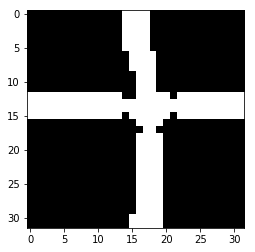

Label: 10


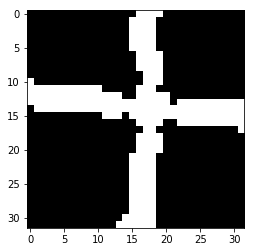

Label: 10


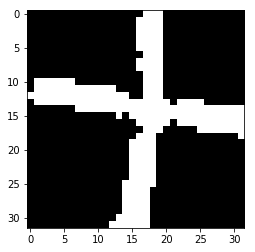

Label: 10


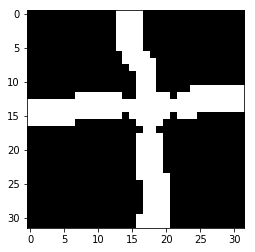

Label: 10


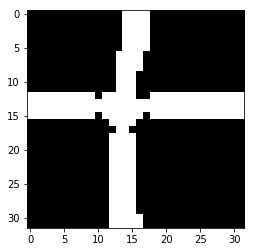

Label: 10


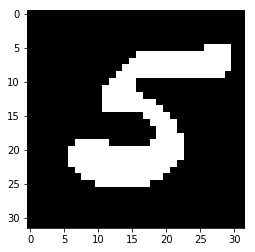

Label: 5


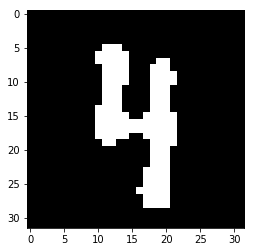

Label: 4


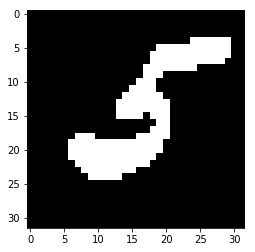

Label: 5


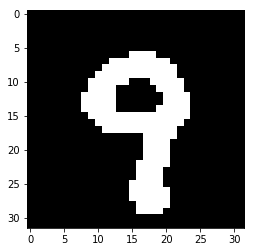

Label: 9


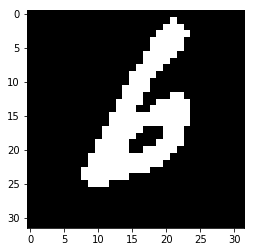

Label: 6


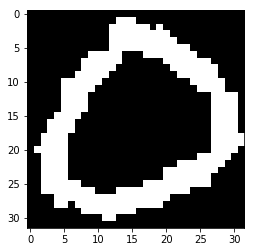

Label: 0


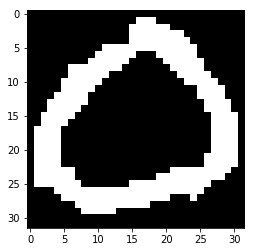

Label: 0


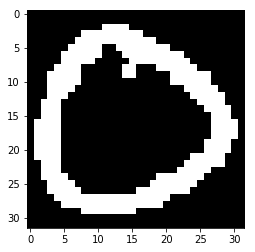

Label: 0


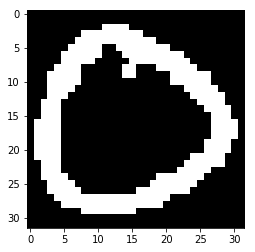

Label: 0


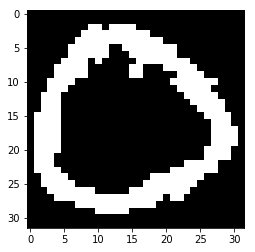

Label: 0


In [2]:
# Plot some images for control

from torchvision import transforms
for i in range(5):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])
for i in range(2000, 2005):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])
for i in range(61000, 61005):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])

In [3]:
# Declare the network and some utilities

from torchvision import models
from torch.nn import Conv2d

pretrained = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch_model = models.alexnet(num_classes=15)
torch_model.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
if pretrained:
    torch_model.load_state_dict(torch.load('pretrained-model-01.ckpt'))
if torch.cuda.is_available():
    torch_model.to(device)
epochs = 11
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001, betas=(0.8, 0.99), weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

def calc_accuracy(model):
    accuracies = []
    for idx, [x_test, y_test] in enumerate(tqdm(test_loader)):
        if torch.cuda.is_available():
            x_test, y_test = x_test.to(device), y_test.to(device)
        test_pred = model(x_test)
        accuracy = 100 * torch.mean((torch.argmax(test_pred, dim=1) == y_test).float())
        accuracies.append(accuracy)
    return np.mean(accuracies)  

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=False)

print(torch_model)
print(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3):

In [4]:
for epoch in range(epochs):
    print("Epoch {0}".format(epoch))
    acc = calc_accuracy(torch_model)
    print("Accuracy: {0}".format(acc))
    if acc > 95:
        torch.save(torch_model.state_dict(), 'combined-model-{0}.ckpt'.format(acc))
    for step, [x_train, y_train] in enumerate(tqdm(train_loader)):
        if torch.cuda.is_available():
             x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        train_pred = torch_model(x_train)
        loss = criterion(train_pred, y_train)
        loss.backward()
        optimizer.step()
        if step % 500 == 0:
            print('Loss: {}'.format(loss))
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')

  0%|          | 1/895 [00:00<01:51,  8.05it/s]

Epoch 0


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 0.24441340565681458


  0%|          | 1/4069 [00:00<38:02,  1.78it/s]

Loss: 2.707850694656372


 12%|█▏        | 501/4069 [06:15<50:26,  1.18it/s]  

Loss: 0.777403712272644


 25%|██▍       | 1001/4069 [18:55<1:16:24,  1.49s/it]

Loss: 0.1862073391675949


 37%|███▋      | 1501/4069 [30:55<55:57,  1.31s/it]  

Loss: 0.8644555807113647


 49%|████▉     | 2001/4069 [41:32<48:46,  1.42s/it]  

Loss: 0.16812385618686676


 61%|██████▏   | 2501/4069 [51:34<31:24,  1.20s/it]

Loss: 0.1826057881116867


 74%|███████▍  | 3001/4069 [1:01:10<22:58,  1.29s/it]

Loss: 0.2262161672115326


 86%|████████▌ | 3501/4069 [1:10:45<10:03,  1.06s/it]

Loss: 0.04586755484342575


 98%|█████████▊| 4001/4069 [1:19:33<01:00,  1.12it/s]

Loss: 0.00362493097782135


  0%|          | 2/895 [00:00<00:58, 15.30it/s]

Epoch 1


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 97.61173248291016


  0%|          | 1/4069 [00:00<1:01:35,  1.10it/s]

Loss: 0.0038178861141204834


 12%|█▏        | 501/4069 [07:39<56:45,  1.05it/s]  

Loss: 0.166850745677948


 25%|██▍       | 1001/4069 [15:03<44:22,  1.15it/s] 

Loss: 0.015024542808532715


 37%|███▋      | 1501/4069 [22:30<38:36,  1.11it/s]

Loss: 0.47739672660827637


 49%|████▉     | 2001/4069 [30:32<32:09,  1.07it/s]

Loss: 0.03172226995229721


 61%|██████▏   | 2501/4069 [38:31<25:54,  1.01it/s]

Loss: 0.006680667400360107


 74%|███████▍  | 3001/4069 [46:50<16:31,  1.08it/s]

Loss: 0.0294671431183815


 86%|████████▌ | 3501/4069 [54:35<08:23,  1.13it/s]

Loss: 0.0023303478956222534


 98%|█████████▊| 4001/4069 [1:02:13<01:01,  1.10it/s]

Loss: 0.21666330099105835


  0%|          | 1/895 [00:00<01:42,  8.70it/s]

Epoch 2


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 98.27513885498047


  0%|          | 1/4069 [00:00<1:05:26,  1.04it/s]

Loss: 0.00013521313667297363


 12%|█▏        | 501/4069 [07:51<55:53,  1.06it/s]  

Loss: 0.005605384707450867


 25%|██▍       | 1001/4069 [15:46<47:38,  1.07it/s] 

Loss: 0.006019949913024902


 37%|███▋      | 1501/4069 [23:27<37:33,  1.14it/s]

Loss: 0.0014658123254776


 49%|████▉     | 2001/4069 [30:55<33:48,  1.02it/s]

Loss: 0.005562350153923035


 61%|██████▏   | 2501/4069 [38:16<21:43,  1.20it/s]

Loss: 0.0026358366012573242


 74%|███████▍  | 3001/4069 [45:55<16:13,  1.10it/s]

Loss: 0.00503888726234436


 86%|████████▌ | 3501/4069 [53:37<08:53,  1.07it/s]

Loss: 0.004681944847106934


 98%|█████████▊| 4001/4069 [1:01:15<00:59,  1.14it/s]

Loss: 0.07420895993709564


  0%|          | 2/895 [00:00<00:53, 16.69it/s]

Epoch 3


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 97.52095031738281


  0%|          | 1/4069 [00:00<1:05:23,  1.04it/s]

Loss: 0.01643677055835724


 12%|█▏        | 501/4069 [07:58<50:37,  1.17it/s]  

Loss: 0.44425076246261597


 25%|██▍       | 1001/4069 [15:12<44:35,  1.15it/s] 

Loss: 0.00017914175987243652


 37%|███▋      | 1501/4069 [22:15<35:31,  1.20it/s]

Loss: 0.08702754974365234


 49%|████▉     | 2001/4069 [1:13:10<28:06,  1.23it/s]     

Loss: 0.1542024314403534


 61%|██████▏   | 2501/4069 [1:20:20<20:00,  1.31it/s]

Loss: 0.0019738227128982544


 74%|███████▍  | 3001/4069 [1:26:56<14:40,  1.21it/s]

Loss: 0.016958139836788177


 86%|████████▌ | 3501/4069 [1:33:27<06:55,  1.37it/s]

Loss: 0.029874950647354126


 98%|█████████▊| 4001/4069 [1:39:43<00:51,  1.32it/s]

Loss: 0.011432230472564697


  0%|          | 2/895 [00:00<00:48, 18.28it/s]

Epoch 4


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 98.36592102050781


  0%|          | 1/4069 [00:00<53:20,  1.27it/s]

Loss: 0.000786125659942627


 12%|█▏        | 501/4069 [06:29<46:07,  1.29it/s]

Loss: 0.13624809682369232


 25%|██▍       | 1001/4069 [12:49<38:09,  1.34it/s]

Loss: 0.0005532056093215942


 37%|███▋      | 1501/4069 [18:55<31:48,  1.35it/s]

Loss: 0.0009050667285919189


 49%|████▉     | 2001/4069 [25:39<30:21,  1.14it/s]

Loss: 0.00010943412780761719


 61%|██████▏   | 2501/4069 [32:53<22:22,  1.17it/s]

Loss: 0.005866974592208862


 74%|███████▍  | 3001/4069 [39:15<13:54,  1.28it/s]

Loss: 0.000110626220703125


 86%|████████▌ | 3501/4069 [45:48<07:26,  1.27it/s]

Loss: 0.14990052580833435


 98%|█████████▊| 4001/4069 [52:20<00:51,  1.31it/s]

Loss: 0.00011169910430908203


  0%|          | 2/895 [00:00<00:50, 17.72it/s]

Epoch 5


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 97.7374267578125


  0%|          | 1/4069 [00:00<51:36,  1.31it/s]

Loss: 0.13683415949344635


 12%|█▏        | 501/4069 [06:12<45:46,  1.30it/s]

Loss: 0.03149391710758209


 25%|██▍       | 1001/4069 [12:38<40:49,  1.25it/s]

Loss: 0.05980715900659561


 37%|███▋      | 1501/4069 [19:10<33:30,  1.28it/s]

Loss: 0.0009995698928833008


 49%|████▉     | 2001/4069 [25:28<25:50,  1.33it/s]

Loss: 0.0037041157484054565


 61%|██████▏   | 2501/4069 [31:43<20:08,  1.30it/s]

Loss: 0.0009119212627410889


 74%|███████▍  | 3001/4069 [38:10<13:43,  1.30it/s]

Loss: 0.002463594079017639


 86%|████████▌ | 3501/4069 [44:39<07:30,  1.26it/s]

Loss: 0.0037916898727416992


 98%|█████████▊| 4001/4069 [51:00<00:50,  1.34it/s]

Loss: 0.004324138164520264


  0%|          | 2/895 [00:00<00:51, 17.24it/s]

Epoch 6


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 98.45670318603516


  0%|          | 1/4069 [00:00<51:33,  1.31it/s]

Loss: 0.00900942087173462


 12%|█▏        | 501/4069 [06:19<45:37,  1.30it/s]

Loss: 0.018283262848854065


 25%|██▍       | 1001/4069 [12:46<37:46,  1.35it/s]

Loss: 0.005922779440879822


 37%|███▋      | 1501/4069 [19:00<30:36,  1.40it/s]

Loss: 0.011256873607635498


 49%|████▉     | 2001/4069 [25:14<26:57,  1.28it/s]

Loss: 0.08233737200498581


 61%|██████▏   | 2501/4069 [31:49<20:48,  1.26it/s]

Loss: 0.47936779260635376


 74%|███████▍  | 3001/4069 [38:10<13:30,  1.32it/s]

Loss: 0.5141087770462036


 86%|████████▌ | 3501/4069 [44:46<07:36,  1.24it/s]

Loss: 0.0006131529808044434


 98%|█████████▊| 4001/4069 [51:18<00:50,  1.36it/s]

Loss: 0.016741737723350525


  0%|          | 2/895 [00:00<00:56, 15.69it/s]

Epoch 7


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 98.43575286865234


  0%|          | 1/4069 [00:00<52:12,  1.30it/s]

Loss: 0.0015388727188110352


 12%|█▏        | 501/4069 [06:12<44:29,  1.34it/s]

Loss: 0.0018647611141204834


 25%|██▍       | 1001/4069 [12:33<39:24,  1.30it/s]

Loss: 0.21008580923080444


 37%|███▋      | 1501/4069 [18:36<30:26,  1.41it/s]

Loss: 0.0008376240730285645


 49%|████▉     | 2001/4069 [24:45<26:55,  1.28it/s]

Loss: 0.005515918135643005


 61%|██████▏   | 2501/4069 [31:07<20:29,  1.28it/s]

Loss: 0.0002186894416809082


 74%|███████▍  | 3001/4069 [37:27<13:28,  1.32it/s]

Loss: 0.0004185140132904053


 86%|████████▌ | 3501/4069 [43:46<07:12,  1.31it/s]

Loss: 0.3081287443637848


 98%|█████████▊| 4001/4069 [50:03<00:50,  1.36it/s]

Loss: 0.9761614799499512


  0%|          | 2/895 [00:00<00:54, 16.50it/s]

Epoch 8


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 98.28211975097656


  0%|          | 1/4069 [00:00<49:48,  1.36it/s]

Loss: 0.002550378441810608


 12%|█▏        | 501/4069 [06:06<43:15,  1.37it/s]

Loss: 0.00019419193267822266


 25%|██▍       | 1001/4069 [12:22<40:04,  1.28it/s]

Loss: 0.007553577423095703


 37%|███▋      | 1501/4069 [18:49<32:49,  1.30it/s]

Loss: 0.004746198654174805


 49%|████▉     | 2001/4069 [25:04<26:00,  1.32it/s]

Loss: 0.0042953938245773315


 61%|██████▏   | 2501/4069 [31:18<19:42,  1.33it/s]

Loss: 0.013395041227340698


 74%|███████▍  | 3001/4069 [37:40<13:37,  1.31it/s]

Loss: 0.203399658203125


 86%|████████▌ | 3501/4069 [44:05<07:27,  1.27it/s]

Loss: 0.0013043582439422607


 98%|█████████▊| 4001/4069 [50:31<00:51,  1.33it/s]

Loss: 0.0008966922760009766


  0%|          | 2/895 [00:00<00:47, 18.62it/s]

Epoch 9


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 98.71508026123047


  0%|          | 1/4069 [00:00<51:13,  1.32it/s]

Loss: 0.00850573182106018


 12%|█▏        | 501/4069 [06:03<43:55,  1.35it/s]

Loss: 0.002989545464515686


 25%|██▍       | 1001/4069 [12:05<35:50,  1.43it/s]

Loss: 0.00016111135482788086


 37%|███▋      | 1501/4069 [18:05<31:13,  1.37it/s]

Loss: 0.001066058874130249


 49%|████▉     | 2001/4069 [24:02<23:58,  1.44it/s]

Loss: 0.05278525501489639


 61%|██████▏   | 2501/4069 [29:56<19:11,  1.36it/s]

Loss: 0.0074876099824905396


 74%|███████▍  | 3001/4069 [36:10<13:21,  1.33it/s]

Loss: 0.43129175901412964


 86%|████████▌ | 3501/4069 [42:13<06:34,  1.44it/s]

Loss: 0.173245370388031


 98%|█████████▊| 4001/4069 [48:03<00:49,  1.36it/s]

Loss: 0.0013313591480255127


  0%|          | 2/895 [00:00<00:54, 16.31it/s]

Epoch 10


  0%|          | 0/4069 [00:00<?, ?it/s]

Accuracy: 97.12989044189453


  0%|          | 1/4069 [00:00<51:34,  1.31it/s]

Loss: 0.13708922266960144


 12%|█▏        | 501/4069 [06:19<43:26,  1.37it/s]

Loss: 0.032556161284446716


 25%|██▍       | 1001/4069 [12:08<35:41,  1.43it/s]

Loss: 0.0009244084358215332


 37%|███▋      | 1501/4069 [18:00<30:44,  1.39it/s]

Loss: 0.01189526915550232


 49%|████▉     | 2001/4069 [23:57<23:47,  1.45it/s]

Loss: 0.0026770681142807007


 61%|██████▏   | 2501/4069 [29:48<18:58,  1.38it/s]

Loss: 0.028802186250686646


 74%|███████▍  | 3001/4069 [36:13<14:33,  1.22it/s]

Loss: 0.16301193833351135


 86%|████████▌ | 3501/4069 [42:19<06:07,  1.55it/s]

Loss: 0.006836891174316406


 98%|█████████▊| 4001/4069 [47:53<00:48,  1.41it/s]

Loss: 0.009840041399002075


100%|██████████| 895/895 [00:51<00:00, 17.27it/s]


Accuracy: 98.09357452392578


In [ ]:
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')